In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

Load data

In [11]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Select features for prediction
    features = ['Materials', 'Category', 'Brand', 'Manufacturing Location', 
                'Water Usage (L)', 'Carbon Footprint (kg)', 'Energy Consumption (kWh)']
    target = 'Environmental Impact Score'
    
    X = df[features]
    y = df[target]
    
    return X, y

Preprocessing and model training

In [12]:
def train_environmental_impact_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Preprocessing for different column types
    categorical_features = ['Materials', 'Category', 'Brand', 'Manufacturing Location']
    numeric_features = ['Water Usage (L)', 'Carbon Footprint (kg)', 'Energy Consumption (kWh)']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Define base models
    estimators = [
        ('rf', RandomForestRegressor(n_estimators=120, random_state=42)),
        ('svm', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
        ('knn', KNeighborsRegressor(n_neighbors=5, weights='distance'))
    ]
    
    # Create voting ensemble
    voting_regressor = VotingRegressor(
        estimators=estimators,
        weights=[1, 1, 1]  # Equal weights for all models
    )
    
    # Create pipeline with preprocessor and voting ensemble
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', voting_regressor)
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate ensemble
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Get individual predictions for comparison
    individual_predictions = {}
    for name, estimator in estimators:
        individual_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', estimator)
        ])
        individual_pipeline.fit(X_train, y_train)
        individual_pred = individual_pipeline.predict(X_test)
        individual_predictions[name] = individual_pred
        print(f'{name.upper()} R²: {r2_score(y_test, individual_pred):.4f}')
    
    print("\nEnsemble Performance:")
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')

    return model,y_test,y_pred

RF R²: 0.8116
SVM R²: 0.7014
KNN R²: 0.8757

Ensemble Performance:
Mean Squared Error: 0.0089
R² Score: 0.8415


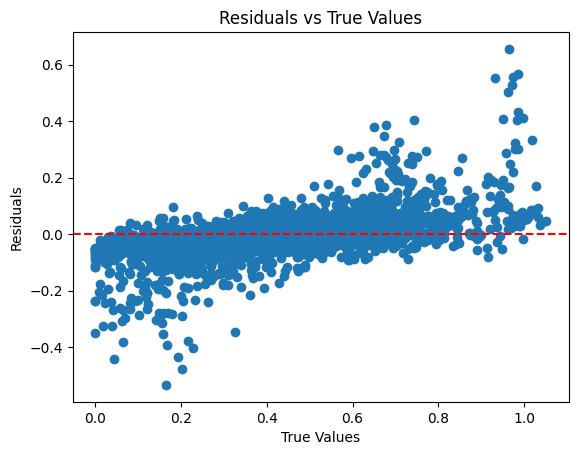

In [13]:

def main(file_path):
    X, y = load_and_preprocess_data(file_path)
    model, y_test, y_pred = train_environmental_impact_model(X, y)
    
    # Residual analysis
    residuals = y_test - y_pred
    plt.scatter(y_test, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs True Values")
    plt.show()
    
    return model

# Run the code
model = main('/workspaces/codespaces-jupyter/env-impact-analyzer/data/augmented_data_final.csv')



In [14]:
import pickle as pkl

# Save model
pkl.dump(model, open('environmental_impact_model.pkl', 'wb'))


In [15]:
import pickle

# Load the trained model
with open('/workspaces/codespaces-jupyter/env-impact-analyzer/environmental_impact_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Example: Test prediction with some new data
product_info = {
    'Materials': 'Plastic',
    'Category': 'Electronics',
    'Brand': 'Brand X',
    'Manufacturing Location': 'Country Y',
    'Water Usage (L)': 500,
    'Carbon Footprint (kg)': 1.2,
    'Energy Consumption (kWh)': 10
}

# Make a prediction
prediction = model.predict([product_info])
print(prediction)


ValueError: Expected 2D array, got 1D array instead:
array=[{'Materials': 'Plastic', 'Category': 'Electronics', 'Brand': 'Brand X', 'Manufacturing Location': 'Country Y', 'Water Usage (L)': 500, 'Carbon Footprint (kg)': 1.2, 'Energy Consumption (kWh)': 10}].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.